# Machine Learning Interatomic Potentials (MLIP) with ESPResSo

In this tutorial, you'll learn how to train and deploy a machine-learned interatomic potential (MLIP) with ESPResSo.
We'll be using the [apax](https://github.com/apaxhub/apax) MLIP framework <a href='#[1]'>[1]</a>.

## Atomistic simulation of water molecule with TIP4P model
We begin with a classical MD simulation of liquid water using the **TIP4P/2005** model. This model is one of the most widely used classical force fields in computational chemistry and material science for accurately representing the structual and thermodynamic properties of water.

The primary objectives of this part of tutorial are:
- To learn how to set up and run an atomistic simulation of water molecules using the TIP4P model
- To explore the structure of liquid water by computing and analyzing the radial distribution function (RDF)
- To establish a reference for later comparison with simulations based on MLIP

This atomistic approach provides a valuable baseline against with more modern methods, i.e. MLIP, can be evaluated in terms of both accuracy and performance.

We will now import the necessary ESPResSo features and external modules and proceed to setup the system.

In [1]:
import espressomd
import espressomd.observables
from pint import UnitRegistry
import numpy as np
import tqdm
import pandas as pd

### Unit
In the first part of tutorial, energies are expressed in $k_{B}T$, distances in *nm*, masses in atomic units and charge in unit chage. And we set the temperature **$T=298.15 K$**. Unit of physical parameters are maged by `UnitRegistry`.

In [2]:
# Simulation units:
# * energy: kT
# * mass: atomic mass unit
# * length: nm
# * charge: unit chage

u = UnitRegistry()
Q_ = u.Quantity

# --- Fundamental constants (CODATA exact where defined) ---
kB = Q_(1.380649e-23, "joule/kelvin")         # Boltzmann constant
T = Q_(298.15, "kelvin")                      # temperature
u.define(f"kT = {(kB*T).to('joule')}")
u.define("e = 1.602176634e-19 coulomb")           # elementary charge
eps0 = Q_(8.8541878128e-12, "farad/meter")    # vacuum permittivity (F/m)
NA = Q_(6.02214076e23, "1 / mole")            # Avogadro constant

# System size
L = 2.5  # nm

### TIP4P model
The TIP4P model is a classical, rigid water model designed to simulate the water molecular behaviour in MD and Monte Carlo simulations. Unlike simpler models, such as TIP3P or SPC, which use three interaction sites, in the TIP4P model, the water molecule consists of four fixed interaction sites arranged as a rigid body:

- Two hydrogen atoms, each with a positive partial charge **q_H**.
- One oxygen atom, which participates in Lennard-Jones interactions but carries no charge.
- A massless dummy site (called the M site) located slightly offset, **d_OM**, from the oxygen atom along the bisector of the H-O-H angle. The negative partial charge of the molecule, **q_M**, is assined to this M site.

This fixed geometry, maintained through rigid constraints, allows efficient simulations with larger time steps. More importantly, the placement of the negative charge at the M site enhances the electrostatic representation, particularly improveing the dipole and quadrupole moments of the water molecule.

Among its variants, **TIP4P/2005**(https://doi.org/10.1063/1.2121687) is particularly well-regarded for accurately key structural and thermodynamic properties of water. While slightly more computationally demanding than three-site model, TIP4P/2005 offers a strong balance between physical realism and performance.

<img src="TIP4P.png" alt="TIP4P" width="400"/>

Therefore, we set parameters for moleculary geometry and Lennard-Jones potential following TIP4P/2005.

**Exercise:**
- Set following parameters:
  - `OO_SIGMA`: The sigma for Lennard-Jones interactions between oxygen
  - `OO_EPSILON`: The (dimensionless) interaction strength epsilon for Lennard-Jones interactions between oxygen
  - `R_OH`: The distance between oxygen and hydrogen
  - `theta`: H-O-H angle
  - `d_OM`: The distance between oxygen and the M site
  - `q_H`: a partial charge for hydrogen
  - `q_M`: a partial charge for the M site

**Hint:**
- All parameters are wrriten in the paper(https://doi.org/10.1063/1.2121687).

In [3]:
#SOLUTION CELL

# --- TIP4P/2005 Lennard-Jones (oxygen site) ---
OO_SIGMA = 0.31589   # nm
#OO_EPSILON = (Q_(0.1852, "kcal/mole") / NA / (kB*T)).to("dimensionless").magnitude
OO_EPSILON = (Q_(93.2, "kelvin") / T).to("dimensionless").magnitude

# --- TIP4P/2005 Geometrie (nm) ---
R_OH = 0.09572  # nm
theta = np.radians(104.52)
d_OM = 0.01546  # nm
q_H = +0.5564  # e
q_M = -1.1128  # e


The geometry of water molecule is definedaccording to TIP4P/2005.

**Exercise:**
- Specify the geometry of water molecule for TIP4P/2005 by setting follwing parameters(np.array):
  - `O_loc`: Position of oxygen
  - `H1_loc`: Position of hydrogen 1
  - `H2_loc`: Position of hydrogen 2
  - `M_loc`: Position of the M site

**Hint:**
- Only the relative positions need to be defined. For simplicity, you can place all atoms in the same plane. For example `O_loc` at the origin and `H1_loc` on the x-axis. Then place the other atoms according to the model description.

In [4]:
#SOLUTION CELL

O_loc = np.array([0.0, 0.0, 0.0])
H1_loc = np.array([R_OH, 0.0, 0.0])
H2_loc = np.array([R_OH*np.cos(theta),  R_OH*np.sin(theta), 0.0])
M_loc = np.array([d_OM*np.cos(theta/2.0), d_OM*np.sin(theta/2.0), 0.0])


Other parameters are adjust to match actual physical constants.

In [5]:
# masses
O_MASS = 15.9994  # amu
H_MASS = 1.008  # amu
# center of mass position
COM = (O_MASS*O_loc + H_MASS*(H1_loc+H2_loc))/(O_MASS+2*H_MASS)

# number density of water molecules
WATER_DENSITY = Q_(0.997, "g/cm^3")
TIP4P_MASS = Q_(O_MASS+2*H_MASS, "g/mole")
RHO_N = (WATER_DENSITY/TIP4P_MASS*NA).to("1/nm^3").magnitude

COULOMB_CONSTANT = 1/(4*np.pi * eps0.to("e^2/kT/nm")).magnitude

### Setup system
We set siystem size **L=2.5 nm**, and the number of water molecule **n_waters** via **RHO_N[$nm^{-3}$]**.

In [6]:
system = espressomd.System(box_l=[L, L, L])
system.time_step = 0.01
system.cell_system.skin = 0.1

n_waters = int(RHO_N*system.volume())

### Add particle into system with rigid constrain
In this step, we inrtroduce particles into the system and apply a rigid constrain so that they move as a rigid body.

**Exercise:**
- Write a function `rigid_constrain` to create rigid arrangements of particles.
- The function should place the particles in the correct geometry and ensure that they remain fixed relative to one another during the simulation.

**Hint:**
- In ESPResSo, rigid arrangements of particles can be introduced via `vs_auto_relate_to` (https://espressomd.github.io/doc/particles.html#rigid-arrangements-of-particles).
- One particle is choson as the virtual site, and the other particle' position are defined relative to it.

In [7]:
#SOLUTION CELL

def rigid_constrain(p, C):
    p.vs_auto_relate_to(C)


In [8]:
def rand_unit_quaternion():
    # Marsaglia: gleichverteilte Rotation
    u1, u2, u3 = np.random.random(), np.random.random(), np.random.random()
    q1 = np.sqrt(1-u1)*np.sin(2*np.pi*u2)
    q2 = np.sqrt(1-u1)*np.cos(2*np.pi*u2)
    q3 = np.sqrt(u1)*np.sin(2*np.pi*u3)
    q4 = np.sqrt(u1)*np.cos(2*np.pi*u3)
    return np.array([q4, q1, q2, q3])  # (w, x, y, z)


def quat_to_rotmat(q):
    w, x, y, z = q
    return np.array([
        [1-2*(y*y+z*z),   2*(x*y - z*w),   2*(x*z + y*w)],
        [2*(x*y + z*w),   1-2*(x*x+z*z),   2*(y*z - x*w)],
        [2*(x*z - y*w),   2*(y*z + x*w),   1-2*(x*x+y*y)]
    ])


def place_tip4p(center, mol_id):
    R = quat_to_rotmat(rand_unit_quaternion())
    def X(v): return (R @ v) + center - COM
    C = system.part.add(pos=center, type=4, mass=2*H_MASS +
                        O_MASS, rotation=[True, True, True], mol_id=mol_id)
    O = system.part.add(pos=X(O_loc), q=0.0, type=0, mol_id=mol_id)
    H1 = system.part.add(pos=X(H1_loc), q=q_H, type=1, mol_id=mol_id)
    H2 = system.part.add(pos=X(H2_loc), q=q_H, type=1, mol_id=mol_id)
    M = system.part.add(pos=X(M_loc),  q=q_M, type=2, mol_id=mol_id)
    for p in M, O, H1, H2:
        rigid_constrain(p, C)

    return (C, O, H1, H2, M)

In [9]:
positions = system.box_l * np.random.random((n_waters, 3))
for i, pos in enumerate(positions):
    place_tip4p(pos, i)

In the TIP4P model, only the oxygen atoms, type=0 in this tutorial, interact via Lennard-Jones potential.

In [10]:
system.non_bonded_inter[0, 0].lennard_jones.set_params(
    epsilon=OO_EPSILON, sigma=OO_SIGMA, cutoff=2.5*OO_SIGMA, shift="auto")

### Steepest Descent
We use steepset descent to minimize the energy of the system.

In [11]:
print("Overlap removal")
system.integrator.run(0, recalc_forces=True)
system.integrator.set_steepest_descent(
    f_max=1, max_displacement=0.01, gamma=1E-10)
center_particles = system.part.select(type=4)
while np.amax(np.abs(center_particles.f)) > 10:
    force = np.amax(np.abs(center_particles.f))
    print("  maximum force:", force)
    max_disp = 0.005
    system.integrator.set_steepest_descent(
        f_max=0, max_displacement=max_disp, gamma=max_disp/force)
    system.integrator.run(10)
system.integrator.set_vv()
print("Done")

Overlap removal
  maximum force: 142339932251635.94
  maximum force: 2697328949796.6675
  maximum force: 83694542220.88942
  maximum force: 4040391143.455941
  maximum force: 324610545.0119336
  maximum force: 32701327.270339537
  maximum force: 4304067.546232291
  maximum force: 760323.4937039812
  maximum force: 174334.6351973712
  maximum force: 44549.104125568076
  maximum force: 13280.764110109763
  maximum force: 4951.928410928027
  maximum force: 1962.6164238931958
  maximum force: 1118.643087980477
  maximum force: 528.2261607920892
  maximum force: 241.83492739594786
  maximum force: 161.35687785593726
  maximum force: 96.27990786350367
  maximum force: 55.2574945591131
  maximum force: 35.224457306877795
  maximum force: 28.198229572683594
  maximum force: 20.881174589926825
  maximum force: 19.989171326149837
  maximum force: 14.60187854299827
  maximum force: 28.390380613100472
  maximum force: 11.362170861434544
  maximum force: 31.068588708050253
  maximum force: 11.12635

### Equilibration
Then, we activate the Langevin thermostat and run a warmup integration using Velocity Verlet algorithm. The target temperature is **298.15** K.

**Exercise:**
- Enable the Langevin thermostat with $T=298.15 K$. In ESPResSo, this can be done with `system.thermostat.set_langevin(...)`.

**Hint:**
- The unit of energy is already set to $k_{B}T$.

In [12]:
#SOLUTION CELL

system.thermostat.set_langevin(kT=1, gamma=1, seed=1)


In [13]:
# replace singel O particle by molecules
print("Equilibrate without electrostatics")
for i in tqdm.trange(1000, ncols=120):
    system.integrator.run(1)

Equilibrate without electrostatics


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 43.26it/s]


### Incorporate electrostatic interaction
The accuracy of the P3M solver was set to 1e-3.

In [14]:
print("Setup P3M")
p3m = espressomd.electrostatics.P3M(prefactor=COULOMB_CONSTANT, accuracy=1E-3)
system.electrostatics.solver = p3m
print("tunking skin")
print(system.cell_system.tune_skin(
    min_skin=0.05, max_skin=0.2, tol=0.01, int_steps=100))

Setup P3M
CoulombP3M tune parameters: Accuracy goal = 1.00000e-03 prefactor = 5.60459e+01
System: box_l = 2.50000e+00 # charged part = 1560 Sum[q_i^2] = 9.65893e+02
mesh cao r_cut_iL    alpha_L     err       rs_err    ks_err    time [ms]
12   7   4.60000e-01 8.05409e+00 2.526e+00 7.071e-04 2.526e+00 accuracy not achieved
14   7   4.60000e-01 8.05409e+00 5.954e-01 7.071e-04 5.954e-01 accuracy not achieved
16   7   4.60000e-01 8.05409e+00 1.481e-01 7.071e-04 1.481e-01 accuracy not achieved
18   7   4.60000e-01 8.05409e+00 4.347e-02 7.071e-04 4.347e-02 accuracy not achieved
20   7   4.60000e-01 8.05409e+00 1.534e-02 7.071e-04 1.532e-02 accuracy not achieved
22   7   4.60000e-01 8.05409e+00 6.269e-03 7.071e-04 6.229e-03 accuracy not achieved
24   7   4.60000e-01 8.05409e+00 2.908e-03 7.071e-04 2.821e-03 accuracy not achieved
26   7   4.60000e-01 8.05409e+00 1.558e-03 7.071e-04 1.388e-03 accuracy not achieved
28   7   4.60000e-01 8.05409e+00 1.017e-03 7.071e-04 7.307e-04 accuracy not achiev

Then, we equilibrate the system with P3M.

In [15]:
print("Equilibrate with P3M")
tbar = tqdm.trange(1000, ncols=120)
for idx in tbar:
    system.integrator.run(1)

Equilibrate with P3M


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.66it/s]


### Production run
Here, we carry out a pruduction run. During it, we periodically measure the RDF between oxygen.

In [16]:
print("Sampling")
rdfs = []
rdf_bins = 70
r_min = 0.0
r_max = 0.7  # nm
o_ids = system.part.select(type=0).id
rdf_obs = espressomd.observables.RDF(
    ids1=o_ids, ids2=o_ids, n_r_bins=rdf_bins, min_r=r_min, max_r=r_max)

for i in tqdm.trange(30, ncols=120):
    system.integrator.run(50)
    rdfs.append(rdf_obs.calculate())
rdf = np.mean(rdfs, axis=0)
rdf_err = np.std(rdfs, axis=0)/np.sqrt(len(rdfs))
bin_centers = rdf_obs.bin_centers()

Sampling


100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [01:18<00:00,  2.61s/it]


### Plot
We plot oxygen-oxygen RDF obtained by TIP4P/2005 and experimental data (https://doi.org/10.1016/S0301-0104(00)00179-8).
Since Van der waals radius of oxygen is 1.5 Å, the first peak in RDF should be arund 3 Å. Due to the tetrahedral structure of water at 298.15 K, the second peak in RDF should appears at about 1.5-1.6 times the Van der waals diamter, corresponding to a distance of approximately 4.5-4.8 Å.

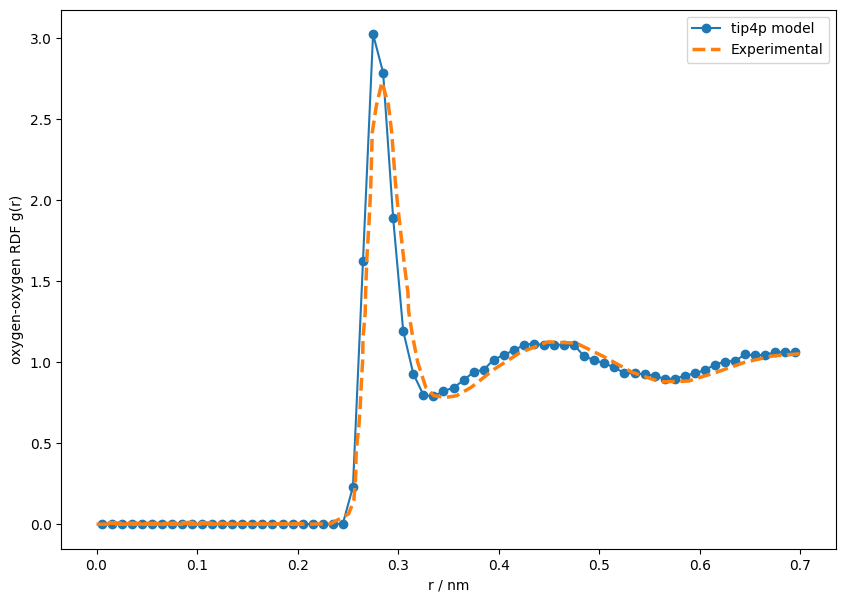

In [17]:
# Plot RDF
import matplotlib.pyplot as plt

#df = pd.read_csv("rdf_water.csv", header=None)
data = np.load("rdf_experiment.npz")

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(bin_centers, rdf, marker='o', label='tip4p model')
#ax.plot(bin_centers, np.ones(bin_centers.size))
ax.plot(0.1*data['rs'], data['rdf'], lw=2.5, ls="dashed", label='Experimental')
plt.legend()
plt.xlabel(r'r / nm')
plt.ylabel('oxygen-oxygen RDF g(r)')
plt.show()

# For later tutorial, save RDF from TIP4P/2005
np.savez("rdf_tip4p.npz", rdf=rdf, rs=bin_centers)